# Deduplicate dataset using Sentence Transformers

In [1]:
!pip install faiss-cpu
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 56.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=61d562eb4d057bb2c81c6735f26d88d41e865c95e3627c2ba5169d6a006a3a5d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import random
import os
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoModel, BertForSequenceClassification, BertModel
from transformers import AutoTokenizer, BertTokenizer
from transformers import AutoConfig

from torch.optim.lr_scheduler import StepLR
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, notebook

import faiss
from sentence_transformers import SentenceTransformer, util

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

SEED = 55
seed_everything(SEED)

Device:  cuda


In [71]:
data_df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
len(data_df)

50000

In [72]:
data_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [74]:
data_df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

<Axes: xlabel='sentiment', ylabel='count'>

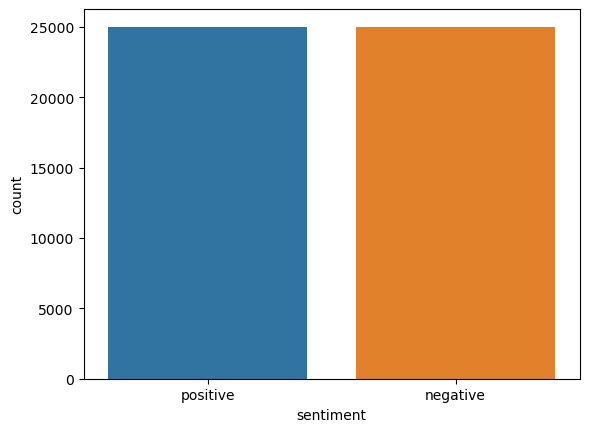

In [75]:
sns.countplot(data=data_df, x='sentiment')

In [9]:
# def combine_labels(label):
#     if 'Positive' in label:
#         return 'Positive'
#     elif 'Negative' in label:
#         return 'Negative'
#     else:
#         return label

In [10]:
# data_train_df['Label'] = data_train_df['Sentiment'].apply(lambda x: combine_labels(x))
# data_test_df['Label'] = data_test_df['Sentiment'].apply(lambda x: combine_labels(x))

Only working on positive/negative labels for experimentation purpose on binary classifcation

In [78]:
labels = {'positive':0, 'negative':1}
data_df['sentiment'] = data_df.sentiment.apply(lambda x: labels[x])
data_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [79]:
cfg = {}
BERT = 'bert-base-uncased'
DISTIL_BERT = 'distilbert-base-uncased'
ROBERTA = 'roberta-base'
MODEL_PATH = DISTIL_BERT

In [80]:
X_train, X_temp, y_train, y_temp = train_test_split(data_df.review, data_df.sentiment, test_size=0.2, random_state=SEED, stratify=data_df.sentiment)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

In [81]:
len(X_train), len(X_val), len(X_test)

(40000, 5000, 5000)

In [82]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [83]:
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [85]:
positive_train_set = train_df[train_df['sentiment'] == 0].review.values
negative_train_set = train_df[train_df['sentiment'] == 1].review.values
len(positive_train_set), len(negative_train_set)

(20000, 20000)

In [86]:
paraphrases_pos = util.paraphrase_mining(embedder, positive_train_set)

In [87]:
# for paraphrase in paraphrases_pos[5500:5505]:
#     score, i, j = paraphrase
#     print("{} \t\t {} \t\t Score: {:.4f}, Index - {}, {}".format(positive_train_set[i], positive_train_set[j], score, i, j))
    
pos_dup_ids = [p[2] for p in paraphrases_pos if p[0] > 0.7]
pos_dup_ids[:5]

[11926, 17784, 6658, 4518, 19509]

In [88]:
len(pos_dup_ids), len(set(pos_dup_ids))

(15931, 6294)

In [89]:
paraphrases_neg = util.paraphrase_mining(embedder, negative_train_set)

In [90]:
neg_dup_ids = [p[2] for p in paraphrases_neg if p[0] > 0.7]
neg_dup_ids[:5]

[5407, 8382, 15381, 13625, 16479]

In [91]:
dup_ids = list(set(pos_dup_ids + pos_dup_ids))
train_df = train_df.drop(index=dup_ids).reset_index(drop=True)

In [92]:
len(train_df)

33706

In [93]:
def get_embeddings(data):
    return embedder.encode(data, convert_to_tensor=True)

<Axes: xlabel='sentiment', ylabel='count'>

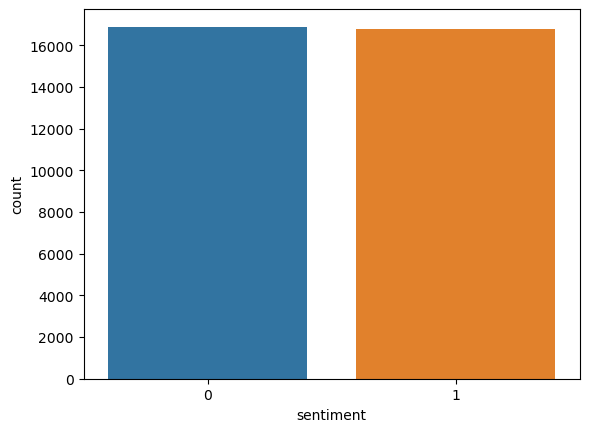

In [95]:
sns.countplot(data=train_df, x='sentiment')

<Axes: xlabel='sentiment', ylabel='count'>

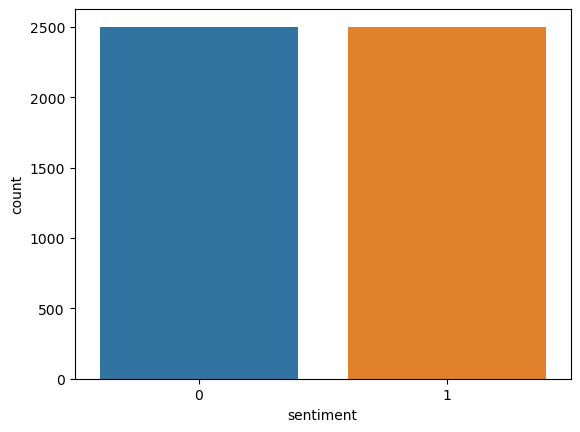

In [96]:
sns.countplot(data=val_df, x='sentiment')

In [97]:
cfg['tokenizer'] ={'name': MODEL_PATH, 'max_length': 256}
tokenizer = AutoTokenizer.from_pretrained(cfg['tokenizer']['name'])

In [98]:
cfg['train_batch_size'] = 32
cfg['valid_batch_size'] = 16
cfg['max_length'] = 256
cfg['epochs'] = 2
cfg['learning_rate'] = 1e-05

In [99]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        comment = self.df.loc[index, 'review']
        inputs = self.tokenizer.encode_plus(
            comment,                                 
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if cfg['tokenizer']['name']=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids'] 
        else:
            token_type_ids = 1.
        
        target = self.df.loc[index, 'sentiment']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
    def __len__(self):
        return self.len

In [100]:
class TweetSentimentBERT(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(TweetSentimentBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name
        
        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == DISTIL_BERT:
            self.in_features = self.bert.transformer.layer[5].output_layer_norm.normalized_shape[0]
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768
            
        self.dense = nn.Linear(self.in_features, self.in_features)
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(self.in_features)
        # self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels))

    def forward(self, input_ids, attention_mask, token_type_ids):    
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == DISTIL_BERT:
            last_hidden_state = self.bert(input_ids,
                                          attention_mask=attention_mask,
                                          return_dict=False)
            first_token_tensor = last_hidden_state[0][:, 0]
            output = self.dense(first_token_tensor)
            output = self.activation(output)
            
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)
        
        output = self.layer_norm(output)
        # output = self.dropout(output)
        output = self.classifier(output)
        return output

In [101]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [102]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    
    print("Start training...\n")
    for epoch in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())
            
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 50 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [103]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [104]:
train_data = TweetDataset(train_df, tokenizer, cfg['max_length'])
val_data = TweetDataset(val_df, tokenizer, cfg['max_length'])
test_data = TweetDataset(test_df, tokenizer, cfg['max_length'])

In [105]:
train_params = {'batch_size': cfg['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [106]:
model = TweetSentimentBERT(MODEL_PATH)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TweetSentimentBERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [107]:
num_training_steps = cfg['epochs']*len(train_loader)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

In [108]:
train(model, loss_function, train_loader, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   50    |   0.532268   |     -      |     -     |   21.04  
   1    |   100   |   0.320028   |     -      |     -     |   20.34  
   1    |   150   |   0.308586   |     -      |     -     |   20.51  
   1    |   200   |   0.286617   |     -      |     -     |   20.57  
   1    |   250   |   0.280249   |     -      |     -     |   20.59  
   1    |   300   |   0.280705   |     -      |     -     |   20.70  
   1    |   350   |   0.256964   |     -      |     -     |   20.51  
   1    |   400   |   0.278380   |     -      |     -     |   20.69  
   1    |   450   |   0.250462   |     -      |     -     |   20.81  
   1    |   500   |   0.279941   |     -      |     -     |   20.67  
   1    |   550   |   0.250790   |     -      |     -     |   20.80  
   1    |   600   |   0.258828   |     -      |     -     |   20.79  


In [109]:
test_loss, test_accuracy = evaluate(model, loss_function, test_loader)
test_loss, test_accuracy

(0.21098425210462496, 91.61341853035144)

Selection using cosine similarity

In [120]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

In [121]:
positive_train_set = train_df[train_df['sentiment'] == 0].review.values
negative_train_set = train_df[train_df['sentiment'] == 1].review.values
len(positive_train_set), len(negative_train_set)

(20000, 20000)

In [122]:
tweet_embeddings_pos = get_embeddings(positive_train_set)
tweet_embeddings_neg = get_embeddings(negative_train_set)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [70]:
negative_train_set[100]

"@hagegeingob @bernard_haufiku  For as long as people keep going to shops it will be hard to contain Covid 19.. To reduce the movement of people we need introduce a concept of shopping online and only let those people that don't have access to Internet do "

In [116]:
query_embedding_pos = get_embeddings(positive_train_set[100])
query_embedding_neg = get_embeddings(negative_train_set[100])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [123]:
%%time

cos_scores_pos = util.cos_sim(query_embedding_pos, tweet_embeddings_pos)
cos_scores_pos.shape

CPU times: user 2.71 ms, sys: 4 µs, total: 2.72 ms
Wall time: 1.98 ms


torch.Size([1, 20000])

In [124]:
%%time

cos_scores_neg = util.cos_sim(query_embedding_neg, tweet_embeddings_neg)
cos_scores_neg.shape

CPU times: user 1.38 ms, sys: 993 µs, total: 2.37 ms
Wall time: 1.95 ms


torch.Size([1, 20000])

In [125]:
ordered_res_pos = torch.topk(cos_scores_pos[0], k=20000)
ordered_res_pos

torch.return_types.topk(
values=tensor([ 1.0000,  0.7592,  0.7224,  ..., -0.0982, -0.1299, -0.1497],
       device='cuda:0'),
indices=tensor([  100,  8324, 12296,  ..., 17488, 18343, 18351], device='cuda:0'))

In [129]:
ordered_res_neg = torch.topk(cos_scores_neg[0], k=20000)
ordered_res_neg

torch.return_types.topk(
values=tensor([ 1.0000,  0.6967,  0.6760,  ..., -0.0682, -0.0876, -0.1015],
       device='cuda:0'),
indices=tensor([  100, 10189,   669,  ...,  6047, 19062,  8534], device='cuda:0'))

In [130]:
pos_ids = ordered_res_pos.indices.detach().cpu().numpy()
neg_ids = ordered_res_neg.indices.detach().cpu().numpy()

In [131]:
pos_ids.shape, neg_ids.shape

((20000,), (20000,))

In [134]:
pos_select_ids = [id for id in pos_ids if id%4 == 0]
neg_select_ids = [id for id in neg_ids if id%4 == 0]
len(pos_select_ids), len(neg_select_ids)

(5000, 5000)

In [142]:
pos_select = positive_train_set[pos_select_ids]
neg_select = negative_train_set[neg_select_ids]

pos_df = pd.DataFrame(pos_select)
pos_df.columns = ['review']
pos_df['sentiment'] = 0

neg_df = pd.DataFrame(neg_select)
neg_df.columns = ['review']
neg_df['sentiment'] = 1

train_df_sub = pd.concat([pos_df, neg_df], axis=0).sample(frac=1).reset_index(drop=True)
train_df_sub.head()

,review,sentiment
0,As a recreational golfer with some knowledge o...,0
1,Let us begin by saying that this film's Englis...,0
2,Luckily for Bill Murray this is such a light-w...,0
3,"As far as HEIST movies go, this one is pretty ...",1
4,A huge cast gathered for this remake which sad...,0


In [143]:
train_df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [144]:
train_data_sub = TweetDataset(train_df_sub, tokenizer, cfg['max_length'])
train_loader_sub = DataLoader(train_data_sub, **train_params)

In [145]:
model_sub = TweetSentimentBERT(MODEL_PATH)
model_sub.to(device)
num_training_steps = cfg['epochs']*len(train_loader_sub)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_sub.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [146]:
train(model_sub, loss_function, train_loader_sub, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   50    |   0.536462   |     -      |     -     |   20.85  
   1    |   100   |   0.359646   |     -      |     -     |   20.60  
   1    |   150   |   0.318662   |     -      |     -     |   20.50  
   1    |   200   |   0.290192   |     -      |     -     |   20.72  
   1    |   250   |   0.301962   |     -      |     -     |   20.79  
   1    |   300   |   0.272839   |     -      |     -     |   20.69  
   1    |   312   |   0.253878   |     -      |     -     |   4.73   
----------------------------------------------------------------------
   1    |    -    |   0.343678   |  0.291028  |   88.00   |  153.93  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------------

In [147]:
test_loss, test_accuracy = evaluate(model_sub, loss_function, test_loader)
test_loss, test_accuracy

(0.24292178764588201, 90.27555910543131)

### Separate

In [111]:
len(train_df_full)

40000

In [112]:
train_data_full = TweetDataset(train_df_full, tokenizer, cfg['max_length'])
train_loader_full = DataLoader(train_data_full, **train_params)

In [113]:
model_full = TweetSentimentBERT(MODEL_PATH)
model_full.to(device)
num_training_steps = cfg['epochs']*len(train_loader_full)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_full.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [114]:
train(model_full, loss_function, train_loader_full, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   50    |   0.596433   |     -      |     -     |   20.79  
   1    |   100   |   0.325749   |     -      |     -     |   20.30  
   1    |   150   |   0.306902   |     -      |     -     |   20.52  
   1    |   200   |   0.258631   |     -      |     -     |   20.64  
   1    |   250   |   0.280044   |     -      |     -     |   20.64  
   1    |   300   |   0.261814   |     -      |     -     |   20.70  
   1    |   350   |   0.278053   |     -      |     -     |   20.73  
   1    |   400   |   0.258173   |     -      |     -     |   20.65  
   1    |   450   |   0.267384   |     -      |     -     |   20.68  
   1    |   500   |   0.291250   |     -      |     -     |   20.69  
   1    |   550   |   0.274632   |     -      |     -     |   20.68  
   1    |   600   |   0.284665   |     -      |     -     |   20.72  


sample 5000 - 5 epochs - 84.04

In [115]:
test_loss, test_accuracy = evaluate(model_full, loss_function, test_loader)
test_loss, test_accuracy

(0.2102576251879644, 92.03274760383387)

Around 0.4 greater than de-duplicated data - 10 % more time.

Random sampling trial

In [148]:
len(train_df_full)

40000

<Axes: xlabel='sentiment', ylabel='count'>

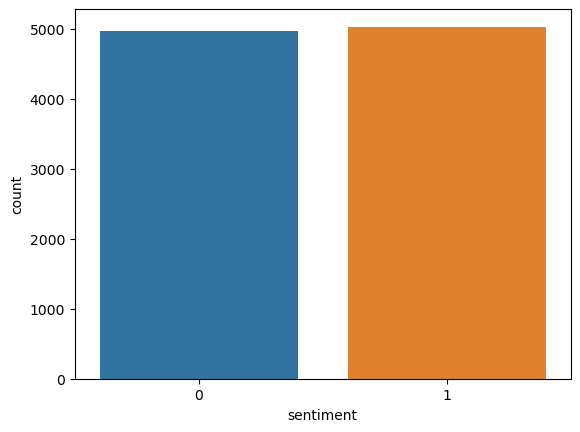

In [149]:
train_df_smpl = train_df_full.sample(n=10000).reset_index(drop=True)
sns.countplot(data=train_df_smpl, x='sentiment')

In [150]:
train_data_smpl = TweetDataset(train_df_smpl, tokenizer, cfg['max_length'])
train_loader_smpl = DataLoader(train_data_smpl, **train_params)

In [151]:
model_smpl = TweetSentimentBERT(MODEL_PATH)
model_smpl.to(device)
num_training_steps = cfg['epochs']*len(train_loader_smpl)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_smpl.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [152]:
train(model_smpl, loss_function, train_loader_smpl, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   50    |   0.477868   |     -      |     -     |   20.80  
   1    |   100   |   0.327477   |     -      |     -     |   20.40  
   1    |   150   |   0.310695   |     -      |     -     |   20.54  
   1    |   200   |   0.301357   |     -      |     -     |   20.66  
   1    |   250   |   0.290467   |     -      |     -     |   20.80  
   1    |   300   |   0.301762   |     -      |     -     |   20.74  
   1    |   312   |   0.322222   |     -      |     -     |   4.83   
----------------------------------------------------------------------
   1    |    -    |   0.334907   |  0.253783  |   89.46   |  154.17  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------------

In [153]:
test_loss, test_accuracy = evaluate(model_smpl, loss_function, test_loader)
test_loss, test_accuracy

(0.23753271386854516, 90.2555910543131)